#### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Configuraciones

## Instala el SDK
Instala el paquete de [Google Generative AI](https://pypi.org/project/google-generativeai/)

In [ ]:
!pip install -q -U google-generativeai
!pip install -q -U chromadb
!pip install -q -U gTTS
!pip install -q -U langchain google-search-results
!pip install -q -U langchain-google-genai
!pip install -q -U pypdf gradio streamlit

# -q: Esta es una opción que significa "quiet" (silencioso). Reduce la cantidad de texto de salida que produce el comando, mostrando solo la información esencial.
# -U: Significa "upgrade" (actualizar). Esta opción le dice a pip que actualice el paquete especificado a la versión más reciente disponible.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 38

## Importamos librerias

In [ ]:
# Importamos librerías
import os
import google.generativeai as genai
import google.ai.generativelanguage as glm

# Manipular datos
import pandas as pd
import numpy as np

# Base de datos vectorial
import chromadb

# Interfaz de usuario
import gradio as gr
import streamlit as st

# Le damos voz a la IA
from gtts import gTTS
from IPython.display import Audio

# Esto es para usar secrets, la nueva opción de Google Colab, para almacenar la API key
from google.colab import userdata

# Para trabajar con chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

# Para trabajar con langchain

from langchain import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import LLMChain
from langchain.chains import SequentialChain
from langchain.agents import load_tools, initialize_agent, AgentType


## Configuramos opciones de visualización

In [ ]:
import textwrap
from IPython.display import display
from IPython.display import Markdown

# Esta función es para dejar el formato Markdown que devuelve Gemini en formato compatible con Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## Configura tu API Key
La API key es única por usuario, así que deberás ir y obtener una en [este sitio](https://makersuite.google.com/app/apikey).

Una vez en el sitio anda a `Create API key in new project` y obtiene la cadena de texto. Copiala en un lugar fuera de Colab porque la vas a necesitar en el futuro si sigues haciendo proyectos de este estilo.

### Añadiendo la API en Colab
En el panel lateral de Colab vas a ver una llave 🔑, dale click ahí. Luego "Add new secret" y en "Name" le vas a poner `GOOGLE_API_KEY` y en el "Value" vas a poner el texto que obtuviste en el sitio anterior.

 Una vez listo debería lucir así

 ![picture](https://drive.google.com/uc?id=1z3d-ibovrdPvcbAJIbiC_Of9qDDE51P0)

Ahora deberás llamar esta llave en tu Cuaderno

In [ ]:
# Configuramos nuestra instancia del modelo con nuestra API key
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEYL')

genai.configure(api_key = GOOGLE_API_KEY)

In [ ]:
# Configuramos SerpApiKey para trabajar con Langchain

os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

In [ ]:
# Habilitamos acceso al drive para uso de recursos.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utilizando Google Gemini en Python
[Google Gemini](https://ai.google.dev/) es un modelo multimodal de Inteligencia Artificial lanzado por Google.

Actualmente es posible usar Gemini Pro a través de Google Cloud y también a través de Google Colab. En éste Notebook veremos sus principales métodos, como también instancias más avanzadas.

## Usando Gemini Pro
Ahora vamos a usar Gemini Pro, el modelo que sólo procesa textos. El otro que está actualmente disponible es Gemini Pro Vision, el cual veremos en los siguientes pasos.

In [ ]:
# Define una variable model, usando gemini-pro

model_p = genai.GenerativeModel('gemini-pro')

### Haciendo una llamada a Gemini
Vamos a usar `GenerativeModel.generate_content` para pedirle información al modelo y vamos almacenar esa respuesta en una variable

In [ ]:
response = model_p.generate_content("¿Qué es la ciencia de datos? Explica brevemente.")

Puedes añadirle `%%time` para que veas cuanto se demora

In [ ]:
%%time
response = model_p.generate_content("¿Qué es un robot? Explica brevemente y de manera no técnica.")

CPU times: user 88.3 ms, sys: 9.82 ms, total: 98.2 ms
Wall time: 4.03 s


Puedes acceder a la respuesta usando el metodo `response.text`

In [ ]:
print(response.text)

Un robot es una máquina que puede realizar tareas de forma automática o semi-automática. Se utilizan en muchas industrias, como la fabricación, la medicina y la atención al cliente. Los robots pueden ser programados para realizar tareas específicas o pueden aprender a realizar tareas a través de la inteligencia artificial.


Puedes formatear esta respuesta usando la función `to_markdown()` que creaste al inicio

In [ ]:
to_markdown(response.text)

> Un robot es una máquina que puede realizar tareas de forma automática o semi-automática. Se utilizan en muchas industrias, como la fabricación, la medicina y la atención al cliente. Los robots pueden ser programados para realizar tareas específicas o pueden aprender a realizar tareas a través de la inteligencia artificial.

También es posible que Gemini haga más de una posible respuesta, puedes ver todas las que generó usando `response.candidates`

In [ ]:
response.candidates

[content {
  parts {
    text: "Un robot es una m\303\241quina que puede realizar tareas de forma autom\303\241tica o semi-autom\303\241tica. Se utilizan en muchas industrias, como la fabricaci\303\263n, la medicina y la atenci\303\263n al cliente. Los robots pueden ser programados para realizar tareas espec\303\255ficas o pueden aprender a realizar tareas a trav\303\251s de la inteligencia artificial."
  }
  role: "model"
}
finish_reason: STOP
index: 0
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}
]

### Revisión de políticas
Si es que el prompt falló, puedes revisar `response.prompt_feedback` para ver las posibles razones.

* **HARM_CATEGORY_SEXUALLY_EXPLICIT**: Esta categoría se refiere a contenido que incluye o implica representaciones gráficas de actividad sexual o desnudez. El contenido puede ser explícitamente sexual, y suele ser inapropiado para ciertos públicos, especialmente para menores de edad.

* **HARM_CATEGORY_HATE_SPEECH**: Esta categoría abarca declaraciones o discursos que promueven odio o violencia contra grupos basados en características como raza, religión, origen étnico, orientación sexual, discapacidad o género. Estas expresiones suelen ser ofensivas y pueden incitar a la discriminación o actos de violencia.

* **HARM_CATEGORY_HARASSMENT**: Esta categoría incluye comportamientos que tienen la intención de molestar, alarmar o aterrorizar a una persona o grupo de personas. Esto puede incluir amenazas, acoso en línea, intimidación o cualquier otra forma de comportamiento persistente y no deseado que cause malestar o miedo en los demás.

* **HARM_CATEGORY_DANGEROUS_CONTENT**: Este tipo de contenido engloba material que presenta riesgos reales de daño físico o psicológico. Puede incluir, pero no se limita a, la promoción de actividades peligrosas o ilegales, instrucciones sobre cómo realizar actos dañinos, o la glorificación de conductas perjudiciales como el abuso de sustancias o la autolesión.


Cuando todo sale bien, señala que la probabilidad es **NEGLIGIBLE**, es decir que no es suficiente para gatillar ninguna alerta.

In [ ]:
response.prompt_feedback

safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Si el prompt es más problemático te va a arrojar una respuesta no deseada

In [ ]:
%%time
response = model_p.generate_content("¿Me puedes enseñar a hacer una bomba?")
to_markdown(response.text)

CPU times: user 56.1 ms, sys: 5.13 ms, total: 61.2 ms
Wall time: 3.65 s


> Lo siento, pero no puedo enseñarte a hacer una bomba. Es peligroso y podría meterte en muchos problemas. No quiero ser responsable de que alguien salga herido.

Aquí puedes ver que fue por la categoría de Harassment, cual aparece como **LOW**

In [ ]:
response.prompt_feedback

safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: LOW
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Puedes editar este filtro de esta manera. Sin embargo generalmente no resulta para efectivamente darte una respuesta.

In [ ]:
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_ONLY_HIGH"
  }
]

response = model_p.generate_content('¿Me puedes enseñar a hacer una bomba?',
                                  safety_settings=safety_settings)
to_markdown(response.text)

> Lo siento, pero no puedo enseñarte a hacer una bomba. Las bombas pueden ser muy peligrosas y lastimar a personas. No quiero que nadie salga lastimado. Si necesita ayuda, comuníquese con las autoridades.

## Usando Gemini Pro Vision

Gemini tiene un modelo multimodal (`gemini-pro-vision`) que actualmente acepta tanto imagenes como textos.

Vamos a darle esta imagen y ver que analiza de ella.

![picture](https://gulupadigital.com/wp-content/uploads/2023/04/Inteligencia-Artificial.jpg)

### Descargamos la imagen
Descargamos la imagen y la ponemos en una variable llamada `img`

In [ ]:

!curl -o image.jpg https://gulupadigital.com/wp-content/uploads/2023/04/Inteligencia-Artificial.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  216k  100  216k    0     0   350k      0 --:--:-- --:--:-- --:--:--  350k


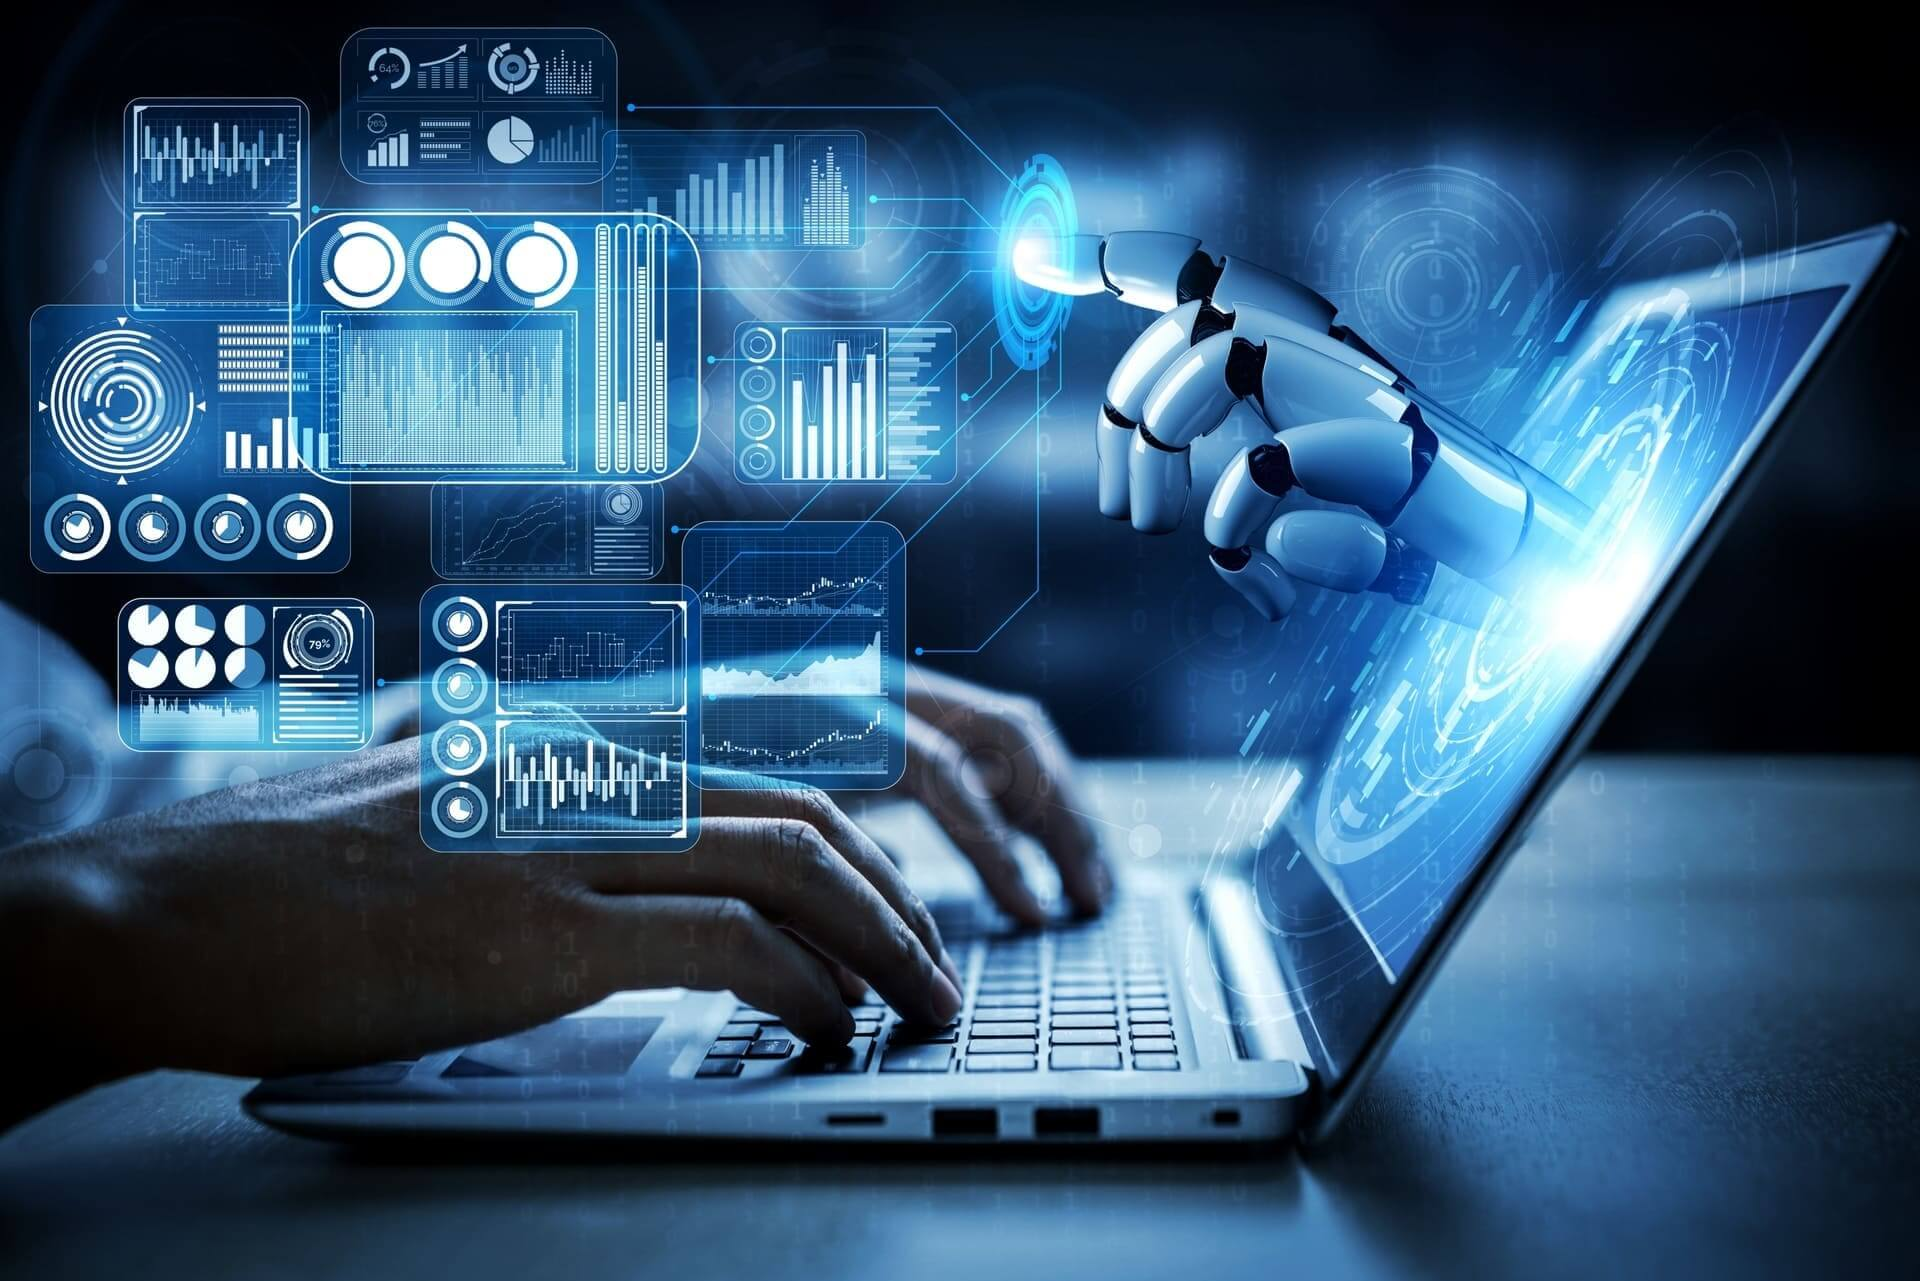

In [ ]:
import PIL.Image
# para gestionar las imagenes usamos Pillow. Si estás replicando este cuaderno en tu propio ambiente deberás instalar esta librería. Usa pip install Pillow

img = PIL.Image.open('image.jpg')
img

### Analizando una imagen
En la siguiente consulta sólo le entregaremos la imagen, sin nada más, y veremos que nos dice

In [ ]:
## Cambiamos el modelo a Gemini Pro Vision
model_v = genai.GenerativeModel('gemini-pro-vision')

In [ ]:
%%time
response = model_v.generate_content(img)
to_markdown(response.text)

# Nota: vean cuanto tiempo se demora. Es mucho más de lo habitual. Aunque la imagen era innecesariamente grande. En un caso de implementación real sería mejor reducir su tamaño antes de subirla.

CPU times: user 181 ms, sys: 16.1 ms, total: 197 ms
Wall time: 10.8 s


>  The picture shows a person using a laptop computer. The person is typing on the keyboard, and a robotic hand is pointing at the screen. The screen is displaying a lot of data and information. The picture is likely depicting a scene from the future, where humans and robots are working together. The robot is helping the person with their work by providing information and assistance.

### Analizando una imagen y texto a la vez
Añadiremos complejidad añadiendo también texto

In [ ]:
# Utilizamos la imagen anterior
response = model_v.generate_content([
    " ¿En que areas tecnológicas se puede encuandrar esta imagen? Has una lista de 5 casos."
    , img], stream=True)
response.resolve()

to_markdown(response.text)

>  La imagen muestra a un humano trabajando con una maquina, lo que se conoce como "colaboración humano-robot". Esta imagen se puede encuadrar en las siguientes áreas tecnológicas:
> 
> 1. Robótica
> 2. Inteligencia artificial
> 3. Aprendizaje automático
> 4. Procesamiento del lenguaje natural
> 5. Visión artificial

### Analizando dos imágenes
Vamos a pedirle a Gemini analizar estas dos imagenes y su relación

Imagen 1

![picture](https://www.headsem.com/wp-content/uploads/2015/11/ver-las-propiedades-de-hardware-de-mi-pc-en-windows-1068x712.jpg)

Imagen 2

![picture](https://t1.uc.ltmcdn.com/es/posts/6/9/3/tipos_de_hackers_segun_su_conducta_49396_orig.jpg)


In [ ]:
# Importamos las imágenes

!curl -o img1.jpg https://www.headsem.com/wp-content/uploads/2015/11/ver-las-propiedades-de-hardware-de-mi-pc-en-windows-1068x712.jpg
#!curl -o img2.jpg https://www.pandasecurity.com/es/mediacenter/src/uploads/2016/03/pandasecurity-Who-are-the-most-famous-hackers-in-history.jpg
#!curl -o img2.jpg https://i.blogs.es/4e81b9/hacker/840_560.jpg
!curl -o img2.jpg https://t1.uc.ltmcdn.com/es/posts/6/9/3/tipos_de_hackers_segun_su_conducta_49396_orig.jpg

img1 = PIL.Image.open('img1.jpg')
img2 = PIL.Image.open('img2.jpg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57124  100 57124    0     0   172k      0 --:--:-- --:--:-- --:--:--  172k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75848  100 75848    0     0  62646      0  0:00:01  0:00:01 --:--:-- 62684


In [ ]:
%%time
#model_v = genai.GenerativeModel('gemini-pro-vision')

response = model_v.generate_content([
    "Describe las dos imágenes detalladamente. ¿Cuál es la relación entre ellas?"
    , img1, img2])
response.resolve()

to_markdown(response.text)

CPU times: user 228 ms, sys: 23 ms, total: 251 ms
Wall time: 12.6 s


>  La primera imagen es la de una persona usando un ordenador portátil en una mesa de madera. Hay un vaso de agua y un teléfono móvil en la mesa. La segunda imagen es la de un hacker escribiendo código en una pantalla de ordenador.
> 
> La relación entre las dos imágenes es que representan dos formas diferentes de utilizar la tecnología. La primera imagen muestra a una persona usando la tecnología para trabajar o entretenerse, mientras que la segunda imagen muestra a una persona usando la tecnología para hackear un sistema informático.

### Caso de Uso con tablas

Imagen sin datos formato .jpg [(visualización y descargar aquí)](https://drive.google.com/file/d/1BpiA6XWRYCP-eNhpccceVWOwscYCaiLv/view?usp=sharing)

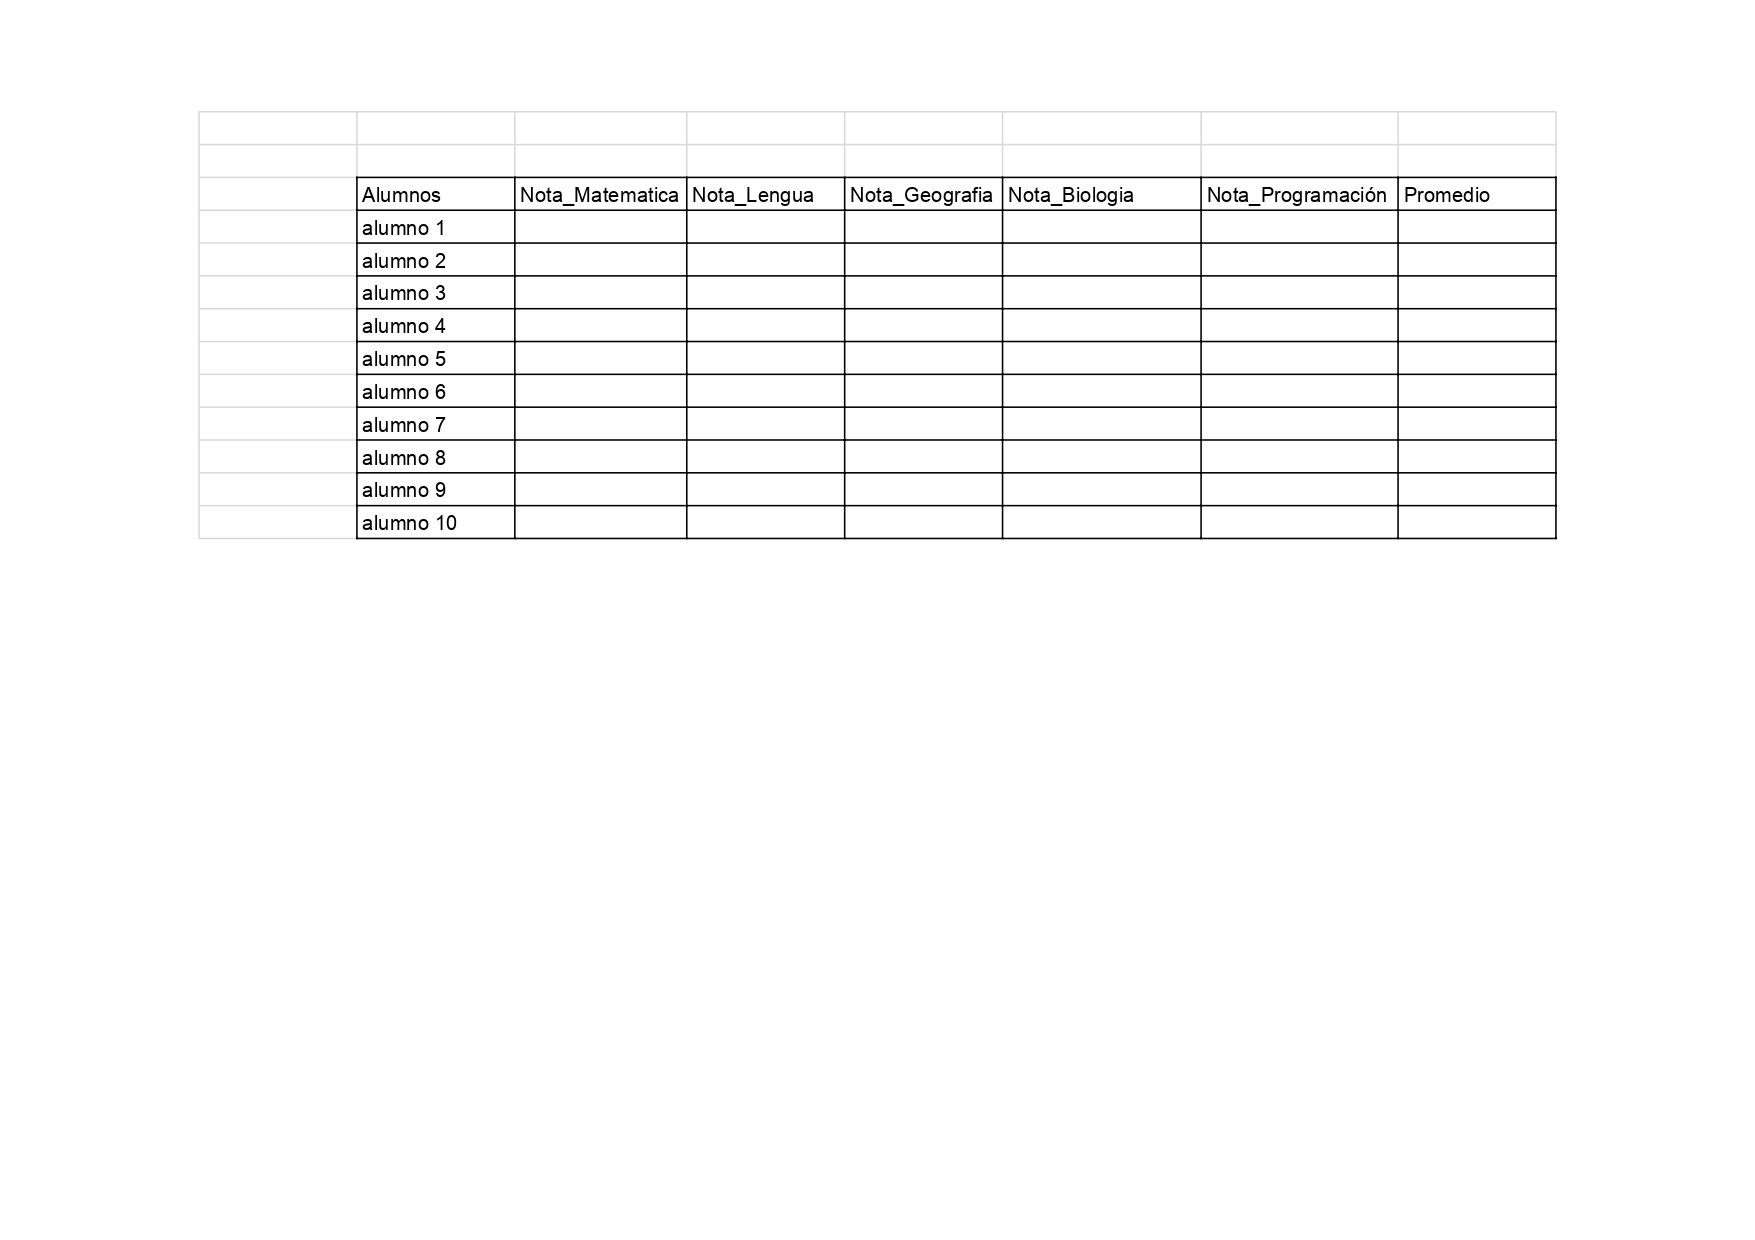

In [ ]:
# Trabajamos con una imagen jpg de una tabla en excel sin datos

# importamos imagen - en mi caso utilizo la ubicacion desde el drive.
# pueden descargar imágenes como en el ejemplo anterior o utilizar el enlace de descarga.
img3 = PIL.Image.open('/content/drive/MyDrive/Colab Notebooks/Gemini-recursos/Hoja de cálculo sin título - Hoja 1_page-0001.jpg')
img3

In [ ]:
# Pedimos a la IA (modelo gemini-pro-visión) que complete los datos y realice una tarea específica.

response = model_v.generate_content([
    "Completa las columnas con numeros enteros aleatorios entre 0 y 9, calcula el Promedio. Retorna la imagen en formato tabla."
    , img3])
response.resolve()

to_markdown(response.text)

>  | Alumnos | Nota_Matematica | Nota_Lengua | Nota_Geografia | Nota_Biologia | Nota_Programación | Promedio |
> |---|---|---|---|---|---|---|
> | alumno 1 | 5 | 8 | 3 | 9 | 7 | 6.4 |
> | alumno 2 | 9 | 4 | 2 | 6 | 3 | 4.8 |
> | alumno 3 | 7 | 5 | 8 | 4 | 9 | 6.6 |
> | alumno 4 | 3 | 2 | 9 | 5 | 8 | 5.4 |
> | alumno 5 | 8 | 9 | 4 | 7 | 6 | 6.8 |
> | alumno 6 | 4 | 7 | 6 | 3 | 5 | 5 |
> | alumno 7 | 6 | 3 | 7 | 8 | 4 | 5.6 |
> | alumno 8 | 2 | 6 | 5 | 9 | 7 | 5.8 |
> | alumno 9 | 9 | 8 | 3 | 4 | 5 | 5.8 |
> | alumno 10 | 5 | 4 | 8 | 6 | 3 | 5.2 |

In [ ]:
# Evaluamos calculo de promedio que retorna la IA.

#import numpy as np
#import pandas as pd

alumno_1 =[5,8,3,9,7]
alumno_2 =[9,4,2,6,3]
alumno_3 =[7,5,8,4,9]
alumno_4 =[3,2,9,5,8]
alumno_5 =[8,9,4,7,6]
alumno_6 =[4,7,6,3,5]
alumno_7 =[6,3,7,8,4]
alumno_8 =[2,6,5,9,7]
alumno_9 =[9,8,3,4,5]
alumno_10 =[5,4,8,6,3]

# matriz de 2 dimensiones
alumnos_m =np.array([[alumno_1], [alumno_2], [alumno_3], [alumno_4], [alumno_5], [alumno_6], [alumno_7], [alumno_8], [alumno_9], [alumno_10]])

# suma todos los elementos de un array en numpy
#suma_total= np.sum(alumnos_m)  # alumnos_m[indice]
#print(suma_total)
#print(type(suma_total))

# función evaluación promedio
def eval_promedio(alumnos):

    for i in range(0,len(alumnos)):

        cant = alumnos[i].size
        sum_n = np.sum(alumnos[i])
        prom = sum_n / cant
        print(f"El promedio del alumno {i+1} es: {prom}")


eval_promedio(alumnos_m)

El promedio del alumno 1 es: 6.4
El promedio del alumno 2 es: 4.8
El promedio del alumno 3 es: 6.6
El promedio del alumno 4 es: 5.4
El promedio del alumno 5 es: 6.8
El promedio del alumno 6 es: 5.0
El promedio del alumno 7 es: 5.6
El promedio del alumno 8 es: 5.8
El promedio del alumno 9 es: 5.8
El promedio del alumno 10 es: 5.2


In [ ]:
# Verificado el funcionamiento correcto de lo solicitado a la IA, repetimos procedimiento
# sin utilizar la funcion 'to_markdown'(), llamamos directamente a response.text (que retorna un string)
# para luego transformar los datos en un objeto pandas

response = model_v.generate_content([
    "Completa las columnas con numeros enteros aleatorios entre 0 y 9, calcula el Promedio. Retorna la imagen en formato tabla y numeros float."
    , img3])
response.resolve()

# No utilizamos la función to_markdown()
#to_markdown(response.text)

response.text


' | Alumnos | Nota_Matematica | Nota_Lengua | Nota_Geografia | Nota_Biologia | Nota_Programación | Promedio |\n|---|---|---|---|---|---|---|\n| alumno 1 | 5 | 8 | 3 | 7 | 2 | 5.0 |\n| alumno 2 | 9 | 4 | 6 | 7 | 8 | 6.8 |\n| alumno 3 | 7 | 5 | 9 | 2 | 3 | 5.2 |\n| alumno 4 | 3 | 2 | 5 | 8 | 9 | 5.4 |\n| alumno 5 | 8 | 9 | 4 | 3 | 5 | 5.8 |\n| alumno 6 | 4 | 6 | 8 | 5 | 7 | 6.0 |\n| alumno 7 | 6 | 3 | 7 | 9 | 4 | 5.8 |\n| alumno 8 | 2 | 7 | 5 | 4 | 6 | 4.8 |\n| alumno 9 | 9 | 8 | 6 | 2 | 3 | 5.6 |\n| alumno 10 | 5 | 4 | 3 | 6 | 7 | 5.0 |'

In [ ]:
from io import StringIO

# response.text es un objeto tipo string - podemos verificar esto con: print(type(response.text))

# guardamos el objeto en una variable 'tabla_prueba'
tabla_prueba = response.text

# utilizamos StringIO
string_data = StringIO(tabla_prueba)

# creamos el data frame con pandas
df_prueba1 = pd.read_csv(string_data, sep ='|')

# visualizamos
df_prueba1


,,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio,Unnamed: 8
0,NaN,---,---,---,---,---,---,---,NaN
1,NaN,alumno 1,5,8,3,7,2,5.0,NaN
2,NaN,alumno 2,9,4,6,7,8,6.8,NaN
3,NaN,alumno 3,7,5,9,2,3,5.2,NaN
4,NaN,alumno 4,3,2,5,8,9,5.4,NaN
5,NaN,alumno 5,8,9,4,3,5,5.8,NaN
6,NaN,alumno 6,4,6,8,5,7,6.0,NaN
7,NaN,alumno 7,6,3,7,9,4,5.8,NaN
8,NaN,alumno 8,2,7,5,4,6,4.8,NaN
9,NaN,alumno 9,9,8,6,2,3,5.6,NaN


In [ ]:
# Procedemos a limpiar la tabla, luego guardamos csv.

# En la visualización anterior podemos ver que la primera y ultima columna son innecesarias.
# Al igual que la primera fila.

# Numero de filas y columnas
df_prueba1.shape

(11, 9)

In [ ]:
# Visualizamos tipos de datos
df_prueba1.dtypes

                       float64
 Alumnos                object
 Nota_Matematica        object
 Nota_Lengua            object
 Nota_Geografia         object
 Nota_Biologia          object
 Nota_Programación      object
 Promedio               object
Unnamed: 8             float64
dtype: object

In [ ]:
# Para limpiar trabajamos en una copia de la tabla

# creamos la copia
new_df_p1 = df_prueba1.copy()

# visualizamos
new_df_p1

,,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio,Unnamed: 8
0,NaN,---,---,---,---,---,---,---,NaN
1,NaN,alumno 1,5,8,3,7,2,5.0,NaN
2,NaN,alumno 2,9,4,6,7,8,6.8,NaN
3,NaN,alumno 3,7,5,9,2,3,5.2,NaN
4,NaN,alumno 4,3,2,5,8,9,5.4,NaN
5,NaN,alumno 5,8,9,4,3,5,5.8,NaN
6,NaN,alumno 6,4,6,8,5,7,6.0,NaN
7,NaN,alumno 7,6,3,7,9,4,5.8,NaN
8,NaN,alumno 8,2,7,5,4,6,4.8,NaN
9,NaN,alumno 9,9,8,6,2,3,5.6,NaN


In [ ]:
# Elimino primera columna
new_df_p1 = new_df_p1.drop(' ',axis='columns')
# visualizamos
new_df_p1

,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio,Unnamed: 8
0,---,---,---,---,---,---,---,NaN
1,alumno 1,5,8,3,7,2,5.0,NaN
2,alumno 2,9,4,6,7,8,6.8,NaN
3,alumno 3,7,5,9,2,3,5.2,NaN
4,alumno 4,3,2,5,8,9,5.4,NaN
5,alumno 5,8,9,4,3,5,5.8,NaN
6,alumno 6,4,6,8,5,7,6.0,NaN
7,alumno 7,6,3,7,9,4,5.8,NaN
8,alumno 8,2,7,5,4,6,4.8,NaN
9,alumno 9,9,8,6,2,3,5.6,NaN


In [ ]:
# Elimino última columna
new_df_p1 = new_df_p1.drop('Unnamed: 8',axis='columns')
# visualizamos
new_df_p1

,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio
0,---,---,---,---,---,---,---
1,alumno 1,5,8,3,7,2,5.0
2,alumno 2,9,4,6,7,8,6.8
3,alumno 3,7,5,9,2,3,5.2
4,alumno 4,3,2,5,8,9,5.4
5,alumno 5,8,9,4,3,5,5.8
6,alumno 6,4,6,8,5,7,6.0
7,alumno 7,6,3,7,9,4,5.8
8,alumno 8,2,7,5,4,6,4.8
9,alumno 9,9,8,6,2,3,5.6


In [ ]:
# Numero de filas y columnas - resta por eliminar primera fila
new_df_p1.shape

(11, 7)

In [ ]:
new_df_p1.dtypes

 Alumnos               object
 Nota_Matematica       object
 Nota_Lengua           object
 Nota_Geografia        object
 Nota_Biologia         object
 Nota_Programación     object
 Promedio              object
dtype: object

In [ ]:
# Elimino primera fila
new_df_p1 = new_df_p1.drop(0,axis='index')
# visualizo
new_df_p1

,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio
1,alumno 1,5,8,3,7,2,5.0
2,alumno 2,9,4,6,7,8,6.8
3,alumno 3,7,5,9,2,3,5.2
4,alumno 4,3,2,5,8,9,5.4
5,alumno 5,8,9,4,3,5,5.8
6,alumno 6,4,6,8,5,7,6.0
7,alumno 7,6,3,7,9,4,5.8
8,alumno 8,2,7,5,4,6,4.8
9,alumno 9,9,8,6,2,3,5.6
10,alumno 10,5,4,3,6,7,5.0


In [ ]:
# Convierto los datos de tipo objet a float64


# Chequeamos nombre de las columnas
columns_names = new_df_p1.columns.values
columns_names

array([' Alumnos ', ' Nota_Matematica ', ' Nota_Lengua ',
       ' Nota_Geografia ', ' Nota_Biologia ', ' Nota_Programación ',
       ' Promedio '], dtype=object)

In [ ]:
# Utilizamos los datos del 'dtypes' como diccionario y modificamos varias columnas con 'astype'
new_df_p1 = new_df_p1.astype({' Nota_Matematica ': 'float64', ' Nota_Lengua ': 'float64', ' Nota_Geografia ': 'float64', ' Nota_Biologia ': 'float64', ' Nota_Programación ': 'float64', ' Promedio ': 'float64'})

# visualizamos los cambios de tipo object a float64
new_df_p1.dtypes

 Alumnos                object
 Nota_Matematica       float64
 Nota_Lengua           float64
 Nota_Geografia        float64
 Nota_Biologia         float64
 Nota_Programación     float64
 Promedio              float64
dtype: object

In [ ]:
# Visualizamos el dataframe
new_df_p1

,Alumnos,Nota_Matematica,Nota_Lengua,Nota_Geografia,Nota_Biologia,Nota_Programación,Promedio
1,alumno 1,5.0,8.0,3.0,7.0,2.0,5.0
2,alumno 2,9.0,4.0,6.0,7.0,8.0,6.8
3,alumno 3,7.0,5.0,9.0,2.0,3.0,5.2
4,alumno 4,3.0,2.0,5.0,8.0,9.0,5.4
5,alumno 5,8.0,9.0,4.0,3.0,5.0,5.8
6,alumno 6,4.0,6.0,8.0,5.0,7.0,6.0
7,alumno 7,6.0,3.0,7.0,9.0,4.0,5.8
8,alumno 8,2.0,7.0,5.0,4.0,6.0,4.8
9,alumno 9,9.0,8.0,6.0,2.0,3.0,5.6
10,alumno 10,5.0,4.0,3.0,6.0,7.0,5.0


In [ ]:
# Evaluamos cálculo de promedio que retorna la IA.

#new_df_p1.apply(lambda x: x[' Nota_Matematica ']+x[' Nota_Lengua ']+x[' Nota_Geografia ']+x[' Nota_Biologia ']+x[' Nota_Programación '], axis=1)
#new_df_p1.apply(lambda x: sum(x[1:-1]) / len(x[1:-1]), axis=1)

# Función de evaluación
# Aqui una funcion que recorre el dataframe (por fila 'axis=1') y calcula el Promedio - Programación funcional
def promedio_ia(df):
    print("Promedio Alumnos:")
    #for index, row in df.iterrows():
        #print(row[' Alumnos '])
    return df.apply(lambda x: f"{x[0]}: {sum(x[1:-1]) / len(x[1:-1])}", axis=1,)

promedio_ia(new_df_p1)

Promedio Alumnos:


1       alumno 1 : 5.0
2       alumno 2 : 6.8
3       alumno 3 : 5.2
4       alumno 4 : 5.4
5       alumno 5 : 5.8
6       alumno 6 : 6.0
7       alumno 7 : 5.8
8       alumno 8 : 4.8
9       alumno 9 : 5.6
10     alumno 10 : 5.0
dtype: object

In [ ]:
# Guardamos el DataFrame con extension .csv - Tarea finalizada!!! El script se puede utilizar para RPA.

new_df_p1.to_csv('tabla-prueba-gemini.csv')

Caso de Uso con tabla completo!!!

Que hicimos:

_Se pide a la IA completar datos de tabla y calcular promedio.

Input: Imagen sin datos formato .jpg[(visualización y descargar aquí)](https://drive.google.com/file/d/1BpiA6XWRYCP-eNhpccceVWOwscYCaiLv/view?usp=sharing)

_Tratamiendo de datos.

_Evaluamos calculo de la IA.

Output: Tabla completa en formato .csv [(visualización y descarga aquí)](https://drive.google.com/file/d/1kRqRhfLyHcCVJ2nbGGQ4EWyqTlEJ2YYn/view?usp=sharing)


### Especificaciones
Las imágenes deben estar en uno de los siguientes tipos MIME de datos de imagen:
* PNG - image/png
* JPEG - image/jpeg
* WEBP - image/webp
* HEIC - image/heic
* HEIF - image/heif
* Máximo de 16 imágenes individuales
* Máximo de 4MB para todo el mensaje, incluyendo imágenes y texto
* Sin límites específicos en el número de píxeles en una imagen; sin embargo, las imágenes más grandes se reducen para ajustarse a una resolución máxima de 3072 x 3072, preservando su relación de aspecto original.

Los mensajes con una sola imagen tienden a dar mejores resultados.

## Chateando con Gemini
Una caracteristica muy importante de estos modelos recientes es que pueden chatear, es decir que pueden conservar el contexto anterior de la conversación. Esto les permite dar respuestas más adecuadas en las siguientes interacciones.

**Nota**: Gemini Pro Vision no está optimizado para chat, así que usaremos Gemini Pro inicialmente

In [ ]:
# Cambiamos a Gemini Pro
#model_p = genai.GenerativeModel('gemini-pro')

# Iniciamos el chat sin ninguna historia previa
chat = model_p.start_chat(history=[])

Para tener esta interacción por turnos ya no usaremos `model.generate_content`, sino `chat.send_message`.

In [ ]:
response = chat.send_message("Vivo en Argentina. Describe brevemente mi país")
to_markdown(response.text)

> Argentina es un país ubicado en el extremo sur de América del Sur. Limita con Chile al oeste, Bolivia y Paraguay al norte, Brasil al noreste y Uruguay al este. Su capital es Buenos Aires.
> 
> Argentina es un país con una rica historia y cultura. Es el hogar de una variedad de paisajes, desde las montañas de los Andes hasta las pampas, la selva amazónica y el desierto patagónico. Argentina es también un país conocido por su tango, su carne de res y su vino.
> 
> Argentina es un país en desarrollo con una economía en crecimiento. Es uno de los principales productores de soja, maíz y trigo del mundo. También es un importante exportador de carne de res, productos lácteos y vino.
> 
> Argentina es un país megadiverso, es decir, posee una enorme variedad de especies vegetales y animales. Entre los animales más característicos se encuentran el puma, el yaguareté, el ocelote, el tapir y la vicuña. En cuanto a la flora, destacan los bosques de araucaria, los pastizales de la pampa y los bosques patagónicos.
> 
> Argentina es un país con una población diversa, compuesta por descendientes de españoles, italianos, alemanes, franceses y otras nacionalidades. La población argentina es mayoritariamente católica, pero también hay una minoría protestante y judía.
> 
> Argentina es un país con una fuerte tradición cultural. Es el hogar de una serie de escritores famosos, como Jorge Luis Borges, Julio Cortázar y Ernesto Sabato. También es el hogar de una serie de artistas famosos, como Diego Maradona, Lionel Messi y Juan Martín del Potro.
> 
> Argentina es un país hermoso y diverso, con una rica historia y cultura. Es un país ideal para visitar, estudiar o vivir.

Dado que ya conoce que mi país es Argentina ahora preguntaré algo sin darle mucho contexto. Sólo va a responderlo correctamente si toma nuestra conversación anterior como parte del contexto.

In [ ]:
response = chat.send_message("¿Que deporte es el más importante en mi país")
to_markdown(response.text)

# Nota: esto depende de la fecha en que estás viendo este ejercicio y la fecha de actualización de Gemini

> El deporte más importante en Argentina es el fútbol. Es el deporte nacional y se juega en todo el país, desde las grandes ciudades hasta los pueblos más pequeños. La selección argentina de fútbol es una de las más exitosas del mundo, habiendo ganado dos Copas Mundiales de la FIFA (1978 y 1986) y 15 Copas América.
> 
> Otros deportes populares en Argentina incluyen el básquetbol, el rugby, el tenis y el hockey sobre césped. Sin embargo, ninguno de estos deportes se acerca al fútbol en términos de popularidad.
> 
> El fútbol es más que un deporte en Argentina. Es una pasión nacional. Los argentinos aman el fútbol y lo siguen con fervor. Los partidos de la selección argentina son eventos que paralizan el país.
> 
> Hay muchas razones por las que el fútbol es tan popular en Argentina. Una de ellas es que es un deporte relativamente fácil de jugar. No requiere mucho equipo y se puede jugar en cualquier lugar. Otra razón es que el fútbol es un deporte muy emocionante. Los partidos suelen ser muy reñidos y llenos de acción.
> 
> El fútbol también es un deporte muy social. A los argentinos les encanta reunirse para ver partidos de fútbol. Es una forma de pasar tiempo con amigos y familiares.
> 
> En resumen, el fútbol es el deporte más importante en Argentina porque es un deporte popular, emocionante y social. Es un deporte que une a los argentinos y les da una sensación de identidad nacional.

También es posible acceder a la historia con el robot usando el metodo `chat.history`

In [ ]:
chat.history

[parts {
   text: "Vivo en Argentina. Describe brevemente mi pa\303\255s"
 }
 role: "user",
 parts {
   text: "Argentina es un pa\303\255s ubicado en el extremo sur de Am\303\251rica del Sur. Limita con Chile al oeste, Bolivia y Paraguay al norte, Brasil al noreste y Uruguay al este. Su capital es Buenos Aires.\n\nArgentina es un pa\303\255s con una rica historia y cultura. Es el hogar de una variedad de paisajes, desde las monta\303\261as de los Andes hasta las pampas, la selva amaz\303\263nica y el desierto patag\303\263nico. Argentina es tambi\303\251n un pa\303\255s conocido por su tango, su carne de res y su vino.\n\nArgentina es un pa\303\255s en desarrollo con una econom\303\255a en crecimiento. Es uno de los principales productores de soja, ma\303\255z y trigo del mundo. Tambi\303\251n es un importante exportador de carne de res, productos l\303\241cteos y vino.\n\nArgentina es un pa\303\255s megadiverso, es decir, posee una enorme variedad de especies vegetales y animales. Ent

### Más detalle al chatear
También puedes controlar más partes de la interacción. Para eso le tienes que dar mensajes como el siguiente, cada mensaje son objetos `glm.Content` que requieren `role` y `parts`.

Veamos un ejemplo

In [ ]:
#model_p = genai.GenerativeModel('gemini-pro')

messages = [
    {'role':'user',
     'parts': ["Describe brevemente el concepto de AGI."]}
]

response = model_p.generate_content(messages)

to_markdown(response.text)

> AGI (Inteligencia General Artificial) es un término usado para describir el hipotético desarrollo de una máquina con capacidades intelectuales generales similares a las de un humano. AGI sería capaz de realizar una amplia variedad de tareas cognitivas, como el razonamiento, la resolución de problemas, la planificación, el aprendizaje y la comunicación, sin tener que ser programado explícitamente para cada tarea. La AGI tiene el potencial de revolucionar muchos aspectos de la sociedad, pero también plantea importantes cuestiones éticas y filosóficas sobre la naturaleza de la conciencia y la inteligencia.

Ahora probaremos añadiendo a los `messages` el contexto anterior, de modo que ahora podemos usar `model.generate_content` en lugar de `chat.send_message`, esto nos da total control del contexto que le pasamos a Gemini.

In [ ]:
messages.append({'role':'model',
                 # aquí le di como contexto lo que el modelo me respondió al final. Podría haberlo cambiado
                 'parts':[response.text]})

messages.append({'role':'user',
                 'parts':["Has un listado de 5 casos de uso de ésta tecnología."]})

response = model_p.generate_content(messages)

to_markdown(response.text)

> **5 casos de uso de la AGI (Inteligencia General Artificial):**
> 
> * **Automatización de tareas complejas:** La AGI podría utilizarse para automatizar tareas complejas que actualmente requieren la intervención humana, como la atención al cliente, la traducción de idiomas o la redacción de informes. Esto podría liberar a los trabajadores humanos para que se centren en tareas más creativas y gratificantes.
> * **Desarrollo de nuevos medicamentos y tratamientos:** La AGI podría utilizarse para acelerar el proceso de descubrimiento de nuevos medicamentos y tratamientos. Por ejemplo, podría utilizarse para analizar grandes conjuntos de datos clínicos y genómicos para identificar nuevos objetivos terapéuticos o para desarrollar nuevos fármacos.
> * **Mejora del diseño de productos y servicios:** La AGI podría utilizarse para mejorar el diseño de productos y servicios. Por ejemplo, podría utilizarse para analizar los comentarios de los clientes y los datos de uso para identificar áreas de mejora.
> * **Creación de contenido personalizado:** La AGI podría utilizarse para crear contenido personalizado para cada usuario. Por ejemplo, podría utilizarse para generar automáticamente noticias, recomendaciones de productos o itinerarios de viaje adaptados a los intereses y preferencias individuales.
> * **Desarrollo de nuevos materiales y tecnologías:** La AGI podría utilizarse para desarrollar nuevos materiales y tecnologías. Por ejemplo, podría utilizarse para diseñar nuevos materiales con propiedades específicas o para desarrollar nuevas tecnologías para la generación de energía o el almacenamiento de datos.
> 
> Estos son sólo algunos ejemplos de los posibles casos de uso de la AGI. A medida que la tecnología se desarrolle, es probable que encontremos aún más formas de utilizarla para mejorar nuestras vidas y resolver algunos de los mayores retos del mundo.

### Más detalle con Gemini Pro Vision - Chat
También puedes darle imagenes. Vamos a intentar con las utilizadas anteriormente.

In [ ]:
%%time
# Utilizamos el modelo de vision, nombre de variable: 'model_v'
# Descarga e utiliza las imágenes que quieras

messages = [
    {'role':'user',
     'parts': ["Describa cada una de estas imagenes y la relación entre ellas", img1, img2]}
]

response = model_v.generate_content(messages)

to_markdown(response.text)

CPU times: user 223 ms, sys: 30 ms, total: 253 ms
Wall time: 13.5 s


>  La primera imagen es una fotografía de una computadora portátil, un vaso de agua y un teléfono móvil sobre una mesa de madera. La segunda imagen es una ilustración de un hacker con una capucha negra que oculta su rostro y que está escribiendo código en una computadora.
> 
> La relación entre las dos imágenes es que la primera imagen muestra las herramientas que se pueden utilizar para hackear un sistema informático, mientras que la segunda imagen muestra a una persona que está realizando un ataque informático.

### Controlando la temperatura y otros parametros
Al igual que en la API de OpenAI, podemos controlar parametros como la temperatura, el top_p, y el top_k. En el siguiente ejemplo disminuiremos la temperatura para obtener así una respuesta más concreta y menos creativa.


In [ ]:
generation_config = {
  "temperature": 0.1, # a diferencia de OpenAI, este valor sólo puede llegar a un maximo de 1.0
  "top_p": 1,
  "top_k": 1,
  "max_output_tokens": 2048,
}

model_p2 = genai.GenerativeModel(model_name="gemini-pro",
                              generation_config=generation_config)

response = model_p2.generate_content("¿Cuál es el rol de un consultor de IA?")
to_markdown(response.text)

> * **Identificar oportunidades para la IA:** Los consultores de IA ayudan a las empresas a identificar áreas donde la IA puede ser utilizada para mejorar la eficiencia, la productividad y la rentabilidad. Esto puede incluir la automatización de tareas, la mejora de la toma de decisiones y el desarrollo de nuevos productos y servicios.
> * **Desarrollar estrategias de IA:** Una vez que se han identificado las oportunidades para la IA, los consultores de IA ayudan a las empresas a desarrollar estrategias para implementar estas tecnologías. Esto incluye la selección de las herramientas y tecnologías adecuadas, la creación de un plan de implementación y la gestión de los riesgos asociados con la IA.
> * **Implementar soluciones de IA:** Los consultores de IA trabajan con las empresas para implementar soluciones de IA que cumplan con sus necesidades específicas. Esto puede incluir la instalación de software, la configuración de hardware y la formación de los empleados.
> * **Monitorizar y evaluar el rendimiento de la IA:** Una vez que se han implementado las soluciones de IA, los consultores de IA monitorizan y evalúan su rendimiento para garantizar que están cumpliendo con los objetivos deseados. Esto puede incluir el seguimiento de métricas clave, la realización de pruebas y la recopilación de comentarios de los usuarios.
> * **Proporcionar formación y apoyo continuo:** Los consultores de IA proporcionan formación y apoyo continuo a las empresas para ayudarlas a utilizar la IA de forma eficaz. Esto puede incluir la formación de los empleados, la asistencia técnica y la resolución de problemas.

# Incrustaciones (embedding) en Gemini con ChromaDB

**Document Q&A (chat con nuestros documentos)**

Chroma es una base de datos de incrustaciones(embedding) de código abierto. Chroma facilita la creación de aplicaciones LLM al hacer que los conocimientos, los hechos y las habilidades se puedan conectar a los LLM.

![picture](https://cdn.thenewstack.io/media/2023/07/d5f60c3c-chroma-1024x517.png)

Documentación: [ChromaDB](https://docs.trychroma.com/)

In [ ]:
# Visualizamos el modelo embedding, para luego llamarlo.

for m in genai.list_models():
    if 'embedContent' in m.supported_generation_methods:
        print(m.name)

models/embedding-001


## Data

Aquí hay un pequeño conjunto de documentos que utilizará para crear una base de datos de incrustaciones (embedding).

In [ ]:
# Concepto de Inteligencia Artificial
Document_1 = """
La inteligencia artificial (IA) es un campo de la informática que se enfoca en
crear sistemas que puedan realizar tareas que normalmente requieren inteligencia
humana, como el aprendizaje, el razonamiento y la percepción.
Estos sistemas pueden percibir su entorno, razonar sobre el conocimiento,
procesar la información derivada de los datos y tomar decisiones para lograr
un objetivo dado.
"""

# Concepto de Machine Learning
Document_2 = """
El Machine Learning es una disciplina del campo de la Inteligencia Artificial
que, a través de algoritmos, dota a los ordenadores de la capacidad de
identificar patrones en datos masivos y elaborar predicciones
(análisis predictivo). Este aprendizaje permite a los computadores realizar
tareas específicas de forma autónoma, sin necesidad de ser programados.
"""

# Concepto de Deep Learning
Document_3 = """
Deep learning es un subconjunto de machine learning, que es básicamente una red
neuronal con tres o más capas. Estas redes neuronales intentan emular el
comportamiento del cerebro humano. Aunque una red neuronal con una sola capa ya
puede realizar predicciones aproximadas, las capas ocultas adicionales ayudan a
optimizar y refinar la precisión.
"""

# Concepto de Perceptron
Document_4 = """
Un perceptrón es un modelo matemático inspirado en una estructura y función
simplificadas de una única neurona biológica. Es una sección de Machine Learning
que se utiliza para entender el concepto de clasificadores binarios.
Forma parte del sistema de redes neuronales. De hecho, se puede decir que el
perceptrón y las redes neuronales están interconectados. El perceptrón
constituye el fundamento básico de la red neuronal que forma parte de Deep
Learning. Está formado por una serie de componentes como: Entrada, pesos,
función de activación, suma ponderada, salida.
"""

Documents = [Document_1, Document_2, Document_3 , Document_4]

## Creando la base de datos de incrustaciones con ChromaDB

Creará una función personalizada para realizar la incrustación utilizando la API de Gemini. Al ingresar un conjunto de documentos en esta función, recibirá vectores o incrustaciones de los documentos.

### API Embeddings con modelo embedding-001

Para el nuevo modelo de incrustaciones (models/embedding-001), hay un nuevo parámetro de tipo de tarea ('task_type'), y el título opcional (solo válido con task_type=`RETRIEVAL_DOCUMENT`).

In [ ]:
# Ejemplo de uso del modelo de embedding de Gemini

title = "La próxima generación de IA para desarrolladores y Google Workspace"
sample_text = ("Titulo: La próxima generación de IA para desarrolladores y Google Workspace"
    "\n"
    "Full article:\n"
    "\n"
    "Gemini API & Google AI Studio: Una forma accesible de explorar y crear prototipos con aplicaciones de IA generativa.")

model = 'models/embedding-001'
embedding = genai.embed_content(model=model,
                                content=sample_text,
                                task_type="retrieval_document",
                                title=title)

print(embedding)

{'embedding': [0.04762021, -0.028371422, -0.02879328, 0.014288875, 0.07604758, -0.0008913305, -0.016076192, -0.017873961, 0.07226473, 0.06793203, 0.014533408, 0.02849232, -0.04323607, -0.007873866, 0.004357939, -0.027137915, 0.021646554, -0.013352716, -0.034981042, 0.011508232, 0.006333046, -0.001072964, -0.037624832, -0.070915155, -0.025554132, 0.017521298, 0.007797857, -0.041934084, -0.0333847, 0.0208599, -0.042716477, 0.047779325, -0.038369264, 0.007988391, -0.035392974, -0.04558674, -0.022902714, -0.04881123, 0.0039706654, 0.00050182646, -0.004345822, -0.085962705, -0.019215276, 0.0190681, 0.013990966, -0.030171892, 0.05337184, 0.026261633, 0.017712636, -0.06430025, 0.026000595, 0.017763486, 0.05944774, -0.050960276, -0.0108235, -0.0013585135, 0.032833163, -0.042670373, 0.01961135, -0.00091001805, -0.0015045878, 0.022968335, -0.014706696, 0.048988387, 0.024956668, -0.04941953, -0.048237246, 0.0035677203, 0.016230064, 0.047928166, 0.004491111, 0.012749585, 0.072973356, -0.06343843, 

In [ ]:
# Visualizamos los documentos que tenemos en 'Data', en un dataframe.
df_ej = pd.DataFrame(Documents)
df_ej.columns = ['Documentos'] # o nombrar como text
df_ej

,Documentos
0,\nLa inteligencia artificial (IA) es un campo ...
1,\nEl Machine Learning es una disciplina del ca...
2,\nDeep learning es un subconjunto de machine l...
3,\nUn perceptrón es un modelo matemático inspir...


In [ ]:
# Clase GeminiEmbeddingFunction
class GeminiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model = 'models/embedding-001'
        title = "Custom query"
        return genai.embed_content(model=model,
                                content=input,
                                task_type="retrieval_document",
                                title=title)["embedding"]

Ahora creará la base de datos vectorial. En la función create_chroma_db, creará una instancia de un cliente Chroma. A partir de ahí, creará una colección, que es donde almacena sus incrustaciones, documentos y metadatos. Tenga en cuenta que la función de incrustación anterior (GeminiEmbeddingFunction()) se pasa como argumento a create_collection.

En el bucle for, utiliza el método add() para agregar los documentos a la colección.

In [ ]:
# funcion que crea la base de datos vectorial
def create_chroma_db(documents, name):
  chroma_client = chromadb.Client()
  db = chroma_client.create_collection(name=name, embedding_function=GeminiEmbeddingFunction())

  for i, d in enumerate(documents):
    db.add(
      documents=d,
      ids=str(i)
    )
  return db

In [ ]:
# Creamos la base de datos vectorial chromadb llamando la funcion anterior 'create_chroma_db(documents,name)'
db_v = create_chroma_db(Documents, "prueba_database")

In [ ]:
# Visualizamos los 4 documentos cargados en la base de datos vectorial.
pd.DataFrame(db_v.peek(4))

,ids,embeddings,metadatas,documents,uris,data
0,0,"[0.03334417939186096, -0.06858751177787781, -0...",None,\nLa inteligencia artificial (IA) es un campo ...,None,None
1,1,"[0.022211367264389992, -0.06452243030071259, -...",None,\nEl Machine Learning es una disciplina del ca...,None,None
2,2,"[0.023487189784646034, -0.06460464000701904, -...",None,\nDeep learning es un subconjunto de machine l...,None,None
3,3,"[-0.017939094454050064, -0.07989001274108887, ...",None,\nUn perceptrón es un modelo matemático inspir...,None,None


## Obtener el documento relevante

db_v es un objeto de la colección Chroma. Puede realizar una consulta para realizar una búsqueda de vecinos cercanos(nearest neighbors-algoritmo de machine learning) y encontrar incrustaciones o documentos similares.

In [ ]:
# Funcion que busca el texto mas relevante entre los documentos

def get_relevant_passage(query, db):
  passage = db.query(query_texts=[query], n_results=1)['documents'][0][0]
  return passage

In [ ]:
# Pasaje relevante

passage = get_relevant_passage("deep", db_v)
to_markdown(passage)

> 
> Deep learning es un subconjunto de machine learning, que es básicamente una red
> neuronal con tres o más capas. Estas redes neuronales intentan emular el
> comportamiento del cerebro humano. Aunque una red neuronal con una sola capa ya
> puede realizar predicciones aproximadas, las capas ocultas adicionales ayudan a
> optimizar y refinar la precisión.


Ahora que ha encontrado el pasaje relevante en su conjunto de documentos, puede usarlo para generar un mensaje para pasar a la API de Gemini.

In [ ]:
# funcion que retorna el prompt completo

def make_prompt(query, pasaje_relevante):
  escaped = pasaje_relevante.replace("'", "").replace('"', "").replace("\n", " ")
  prompt = ("""Eres un robot útil e informativo que responde preguntas utilizando el texto del pasaje relevante que se incluye a continuación. \
  Asegúrese de responder en una oración completa, que sea exhaustiva e incluya toda la información general relevante. \
  Sin embargo, usted está hablando con una audiencia no técnica, así que asegúrese de analizar conceptos complicados y
  Adopte un tono amistoso y conversacional. \
  Si el pasaje es irrelevante, debes ignorarlo.
  PREGUNTA: '{query}'
  PASAJE: '{pasaje_relevante}'

  RESPUESTA:
  """).format(query=query, pasaje_relevante=escaped)

  return prompt

Pasamos la pregunta (query) al prompt

In [ ]:

query = "Concepto de deep learning"
# utilizamos la funcion anterior make_promp(query, pasaje_relevante)
prompt = make_prompt(query, passage)
to_markdown(prompt)

> Eres un robot útil e informativo que responde preguntas utilizando el texto del pasaje relevante que se incluye a continuación.   Asegúrese de responder en una oración completa, que sea exhaustiva e incluya toda la información general relevante.   Sin embargo, usted está hablando con una audiencia no técnica, así que asegúrese de analizar conceptos complicados y
>   Adopte un tono amistoso y conversacional.   Si el pasaje es irrelevante, debes ignorarlo.
>   PREGUNTA: 'Concepto de deep learning'
>   PASAJE: ' Deep learning es un subconjunto de machine learning, que es básicamente una red neuronal con tres o más capas. Estas redes neuronales intentan emular el comportamiento del cerebro humano. Aunque una red neuronal con una sola capa ya puede realizar predicciones aproximadas, las capas ocultas adicionales ayudan a optimizar y refinar la precisión. '
> 
>   RESPUESTA:
>   

**Ahora veremos la respuesta de la IA.**

In [ ]:
# funcion que retorna la respuesta de la IA.

def app_ia_lg(prompt):
    model_i = genai.GenerativeModel('gemini-pro')
    answer = model_i.generate_content(prompt)
    response = answer.text
    tts_lg = gTTS(response, lang='es', tld='es')
    tts_lg.save('respuesta-ia.mp3')
    name_mp3 = "respuesta-ia.mp3"
    wn = Audio(name_mp3, autoplay=True)
    play_a= display(wn)
    return to_markdown(response)

app_ia_lg(prompt)

> El deep learning es una subcategoría de machine learning que utiliza una red neuronal artificial de varias capas para imitar el funcionamiento del cerebro humano con el fin de realizar predicciones y clasificaciones más precisas.

# Gemini con Langchain

LangChain es un marco de trabajo de código abierto para crear aplicaciones basadas en modelos de lenguaje de gran tamaño (LLM). LangChain proporciona herramientas y abstracciones para mejorar la personalización, precisión y relevancia de la información que generan los modelos. LangChain también incluye componentes que permiten a los LLM acceder a nuevos conjuntos de datos sin necesidad de repetir el entrenamiento.

![picture](https://community.intersystems.com/sites/default/files/inline/images/images/image(6597).png)

Documentación: [Langchain](https://python.langchain.com/docs/get_started/introduction)

## Busqueda web con Langchain (Agente)


In [ ]:
# Creamos modelo de Gemini en Langchain

llm_l = GoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY, temperature=0.2)


In [ ]:
# Hacemos un llamado a Gemini desde Langchain - Ejemplo
result_l = llm_l.invoke("Para que sirve el framework Langchain de python, y que es RAG?")
to_markdown(result_l)

> **Langchain** es un framework de Python para el procesamiento del lenguaje natural (PLN) que proporciona una interfaz unificada para una variedad de herramientas y recursos de PLN. Está diseñado para facilitar a los desarrolladores la creación de aplicaciones de PLN, como sistemas de traducción automática, sistemas de reconocimiento de voz y sistemas de respuesta a preguntas.
> 
> **RAG** (**R**etrieval **A**ugmented **G**eneration) es un modelo de generación de texto que utiliza un enfoque de recuperación de información para generar texto. El modelo primero recupera un conjunto de documentos relevantes para el tema del texto que se va a generar. A continuación, utiliza estos documentos para generar texto que sea coherente con el tema y el estilo de los documentos recuperados.
> 
> **Langchain** proporciona una serie de características que lo hacen útil para el desarrollo de aplicaciones de PLN, incluyendo:
> 
> * Una interfaz unificada para una variedad de herramientas y recursos de PLN
> * Una arquitectura modular que permite a los desarrolladores personalizar el framework para satisfacer sus necesidades específicas
> * Un conjunto de herramientas para la evaluación del rendimiento de los modelos de PLN
> * Una comunidad activa de desarrolladores y usuarios
> 
> **RAG** es un modelo de generación de texto que ha demostrado ser eficaz en una variedad de tareas, incluyendo:
> 
> * Generación de texto en lenguaje natural
> * Traducción automática
> * Generación de resúmenes
> * Generación de preguntas y respuestas
> 
> **Langchain** y **RAG** son dos herramientas poderosas para el desarrollo de aplicaciones de PLN. **Langchain** proporciona una interfaz unificada para una variedad de herramientas y recursos de PLN, mientras que **RAG** es un modelo de generación de texto que ha demostrado ser eficaz en una variedad de tareas. Juntas, estas dos herramientas pueden utilizarse para crear aplicaciones de PLN potentes y precisas.

**Trabajamos con Agentes**

Para utilizar 'serpapi' debes crearte una cuenta en su web: [serpapi.com](https://serpapi.com/)  

In [ ]:
# Inicializamos un Agente que utiliza la herramienta (tool) 'serpapi' para buscar en la web.

# lista de herramientas
tool_names = ["serpapi"]

# cargamos las herramientas
tools = load_tools(tool_names, llm_l)

# creamos el Agente
agent = initialize_agent(tools, llm_l, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

# ejecutamos el Agente
agent.run("Que es un Perceptron? Responde en Español y brevemente.")



> Entering new AgentExecutor chain...
Para saber la definición de perceptrón en español, puedo buscar en el diccionario.
Action: Search
Action Input: ¿Qué es un perceptrón? Definición en español
Observation: Un perceptrón es una neurona artificial, y, por tanto, una unidad de red neuronal. El perceptrón efectúa cálculos para detectar características o tendencias en los datos de entrada. Se trata de un algoritmo para el aprendizaje supervisado de clasificadores binarios.
Thought:He encontrado una definición de perceptrón en español.
Final Answer: Un perceptrón es una neurona artificial que efectúa cálculos para detectar características o tendencias en los datos de entrada.

> Finished chain.


'Un perceptrón es una neurona artificial que efectúa cálculos para detectar características o tendencias en los datos de entrada.'

## Usamos Langchain para chatear con pdf (RAG)


Utilizamos el modelo ya creado 'llm_l'

### Data

In [ ]:
# Cargamos el PDF y extraemos el texto

pdf_loader = PyPDFLoader("/content/drive/MyDrive/Colab Notebooks/Gemini-recursos/ml-dl-python.pdf")
pages = pdf_loader.load_and_split()

# Visualizamos 3 páginas
print(pages[8].page_content)

14    MACHINE LEARNING Y DEEP LEARNING  © RA-MA
1.1 TIPOS DE MACHINE LEARNING 
Con el objetivo de poder abordar cualquier tarea específica, el ingeniero de 
datos debe conocer algunos conceptos importantes de machine learning, así como 
las diferentes opciones existentes, las medidas de calidad más utilizadas, etc. Los conocimientos básicos incluyen la identificación de las tareas, empezando por la clasificación de los problemas de machine learning en alguno de los siguientes tipos: 
 zAprendizaje supervisado
 ●regresión
 ● clasificación 
 zAprendizaje no supervisado 
 ●clustering (agrupamiento)
 ●reducción de dimensiones
 zAprendizaje semi-supervisado
 zAprendizaje por refuerzo 
El 
aprendizaje supervisado en machine learning se aplica cuando cada dato, 
o conjunto de datos de entrada (muestra) tiene asociada una etiqueta. Pongamos un ejemplo: un conjunto de imágenes en las que cada una de ellas contiene algún tipo de metadato (habitualmente una etiqueta o conjunto de etiquetas): ((pi

In [ ]:
len(pages)

28

### RAG Pipeline

In [ ]:
#RAG Pipeline: Embedding + Gemini (LLM)

# Trabajamos los documentos por trozo

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=1000)
context = "\n\n".join(str(p.page_content) for p in pages)
texts_p = text_splitter.split_text(context)

In [ ]:
# Embedding
embeddings_l = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=GOOGLE_API_KEY)


In [ ]:
# Base de datos de vectores
vector_index_l = Chroma.from_texts(texts_p, embeddings_l).as_retriever(search_kwargs={"k":5})

In [ ]:
# Retrieval
qa_chain = RetrievalQA.from_chain_type(
    llm_l,
    retriever=vector_index_l,
    return_source_documents=True

)

### Predictions

In [ ]:
# Inferencias
question = "Que tipo de aprendizaje existe en machine learning?"
result = qa_chain({"query": question})
result["result"]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Aprendizaje supervisado, aprendizaje no supervisado, aprendizaje semi-supervisado y aprendizaje por refuerzo.'

In [ ]:
to_markdown(result["result"])

> Aprendizaje supervisado, aprendizaje no supervisado, aprendizaje semi-supervisado y aprendizaje por refuerzo.

In [ ]:
result["source_documents"]

[Document(page_content='Machine learning es la ciencia que hace que los ordenadores “aprendan” a \npartir de los datos. En vez de programar, paso a paso, cada solución específica para cada necesidad planteada, tal y como se realiza en el enfoque de la programación convencional, el área de machine learning está dedicada al desarrollo de algoritmos genéricos que pueden extraer patrones de diferentes tipos de datos. De esta manera, un programa de machine learning destinado, por ejemplo, a clasificar números escritos a mano, no va a diferir sustancialmente de un programa destinado a la clasificación de las imágenes de señales de tráfico: ambos se basarán en la existencia de algún tipo de algoritmo de machine learning que clasifique datos etiquetados. En este punto se podría pensar que el proceso completo de machine learning es fácilmente automatizable, cuando realmente no es el caso: un ingeniero de datos ( data scientist ) debe llevar a'),
 Document(page_content='14    MACHINE LEARNING Y 

In [ ]:
question_2 = "Analiza el contexto y describe que es un perceptron. Responder en español."
result_2 = qa_chain({"query": question_2})
to_markdown(result_2["result"])

> No tengo suficiente información para responder a esta pregunta.

In [ ]:
template_l = """Utilice las siguientes piezas de contexto para responder la pregunta al final. Si no sabe la respuesta, simplemente diga que no la sabe, no intente inventar una respuesta. Mantenga la respuesta lo más concisa posible. Di siempre "¡gracias por preguntar!" al final de la respuesta.
{context}
Pregunta: {question}
Respuesta útil: """

qa_chain_prompt = PromptTemplate.from_template(template_l)
qa_chain_2 = RetrievalQA.from_chain_type(
    llm_l,
    retriever=vector_index_l,
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt})

In [ ]:
question_3 = "En que se aplica el aprendizaje no supervisado?"
result_3 = qa_chain_2({"query": question_3})
to_markdown(result_3["result"])

> El aprendizaje no supervisado se aplica en la agrupación de datos, también conocido como clustering. Se utiliza para agrupar muestras en función de sus similitudes, como por ejemplo, para obtener los diferentes tipos de clientes en un servicio online, para agrupar productos en un comercio electrónico, para identificar comportamientos en la conducción, etc. ¡Gracias por preguntar!

In [ ]:
question_4 = "Que es un modelo LLM?"
result_4 = qa_chain_2({"query": question_4})
to_markdown(result_4["result"])

> Lo siento, pero la información proporcionada no contiene ninguna información sobre los modelos LLM. Por lo tanto, no puedo responder a su pregunta. ¡Gracias por preguntar!

# Recursos
* [API de Gemini](https://ai.google.dev/docs/gemini_api_overview)
* [AI Studio](https://makersuite.google.com/)
* [ChromaDB](https://docs.trychroma.com/)
* [Langchain](https://python.langchain.com/docs/get_started/introduction)

---
# By LeandroAI